In [54]:
# Parameters
total_epochs = 200
learning_rate = 0.001
batch_size = 32
kl_scaling_factor = 10
intermediate_dim_1 = 88
intermediate_dim_2 = 60
latent_dim = 32 


Import statements, file paths, and feature list.

In [55]:
import os
import json
import timeit
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import logging
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import math
import warnings
import itertools
import keras
import re
from tabulate import tabulate
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from scipy.stats import kurtosis, skew, entropy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Layer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, MeanSquaredError
from tensorflow.keras import backend as K, metrics, callbacks
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement
import scrapbook as sb



# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore future warnings

cleaned_data = '../../data/test_data_with_eye_foot_and_drugs_v2_forMI_OE_MICE.csv'

# if uID is still in dataset, leave it in for now
# all_features = [
#     'age', 'duration', 'median_value_hba1c', 'last_value_hba1c', 'n_measures_hba1c', 'iqr_hba1c', 'gradient_values_hba1c',
#     'median_value_sbp', 'last_value_sbp', 'n_measures_sbp', 'iqr_sbp', 'gradient_values_sbp',
#     'median_value_dbp', 'last_value_dbp', 'n_measures_dbp', 'iqr_dbp', 'gradient_values_dbp',
#     'median_value_bmi', 'last_value_bmi', 'n_measures_bmi', 'iqr_bmi', 'gradient_values_bmi',
#     'median_value_acr', 'last_value_acr', 'n_measures_acr', 'iqr_acr', 'gradient_values_acr',
#     'median_value_creat', 'last_value_creat', 'n_measures_creat', 'iqr_creat', 'gradient_values_creat',
#     'median_value_plasma_alb', 'last_value_plasma_alb', 'n_measures_plasma_alb', 'iqr_plasma_alb', 
#     'gradient_values_plasma_alb', 'dm_type_Maturity Onset Diabetes of Youth', 'dm_type_Secondary - Drug Induced',
#     'dm_type_Secondary - Pancreatic Pathology', 'dm_type_Type 1 Diabetes Mellitus', 'dm_type_Type 2 Diabetes Mellitus',
#     'smoking_Current smoker', 'smoking_Ex-smoker', 'smoking_Never smoked', 'smoking_Patient declined',
#     'ethCode_1B', 'ethCode_1C', 'ethCode_1L', 'ethCode_1Z', 'ethCode_2A', 'ethCode_3F', 'ethCode_3G', 'ethCode_3H', 
#     'ethCode_3J', 'ethCode_3Z', 'ethCode_4D', 'ethCode_4Y', 'ethCode_5C', 'ethCode_5D', 'ethCode_6A', 'ethCode_6Z', 
#     'ethCode_98', 'ethCode_99', 'foot_risk', 'eye_risk', 'sex_Male', 'betablockers_prescribed', 'calcium_channel_blockers_prescribed',
#     'angiotensin_receptor_blockers_prescribed', 'ace_inhibitors_prescribed', 'thiazide_diuretics_prescribed', 'loop_diuretics_prescribed',
#     'potassium_sparing_diuretics_prescribed','other_diuretics_prescribed', 'other_antihypertensives_prescribed',
#     'metformin_preparations_prescribed', 'sglt2_inhibitors_prescribed', 'glp1_receptor_agonists_prescribed', 'sulfonylureas_prescribed',
#     'dpp4_inhibitors_prescribed', 'thiazolidinediones_prescribed', 'long_acting_insulins_prescribed', 'short_acting_insulins_prescribed',
#     'intermediate_acting_insulins_prescribed', 'nitrate_drugs_prescribed', 'statin_drugs_prescribed', 'digoxin_preparations_prescribed',
#     'nicorandil_and_related_drugs_prescribed'
# ]

all_features = [
    'age', 'duration', 'median_value_hba1c', 'last_value_hba1c', 'n_measures_hba1c', 'iqr_hba1c', 'gradient_values_hba1c',
    'median_value_sbp', 'last_value_sbp', 'n_measures_sbp', 'iqr_sbp', 'gradient_values_sbp',
    'median_value_dbp', 'last_value_dbp', 'n_measures_dbp', 'iqr_dbp', 'gradient_values_dbp',
    'median_value_bmi', 'last_value_bmi', 'n_measures_bmi', 'iqr_bmi', 'gradient_values_bmi',
    'median_value_acr', 'last_value_acr', 'n_measures_acr', 'iqr_acr', 'gradient_values_acr',
    'median_value_creat', 'last_value_creat', 'n_measures_creat', 'iqr_creat', 'gradient_values_creat',
    'median_value_plasma_alb', 'last_value_plasma_alb', 'n_measures_plasma_alb', 'iqr_plasma_alb', 
    'gradient_values_plasma_alb','dm_type','smoking', 'foot_risk', 'eye_risk', 'sex_Male', 'betablockers_prescribed', 'calcium_channel_blockers_prescribed',
    'angiotensin_receptor_blockers_prescribed', 'ace_inhibitors_prescribed', 'thiazide_diuretics_prescribed', 'loop_diuretics_prescribed',
    'potassium_sparing_diuretics_prescribed','other_diuretics_prescribed', 'other_antihypertensives_prescribed',
    'metformin_preparations_prescribed', 'sglt2_inhibitors_prescribed', 'glp1_receptor_agonists_prescribed', 'sulfonylureas_prescribed',
    'dpp4_inhibitors_prescribed', 'thiazolidinediones_prescribed', 'long_acting_insulins_prescribed', 'short_acting_insulins_prescribed',
    'intermediate_acting_insulins_prescribed', 'nitrate_drugs_prescribed', 'statin_drugs_prescribed', 'digoxin_preparations_prescribed',
    'nicorandil_and_related_drugs_prescribed'
]

# sglt_2_inhibitors_prescribed left out of numerical_features since there are no entries for this in the dataset
numerical_features = [
    'age', 'duration', 'median_value_hba1c', 'last_value_hba1c', 'n_measures_hba1c', 'iqr_hba1c', 
    'gradient_values_hba1c', 'median_value_sbp', 'last_value_sbp', 'n_measures_sbp', 'iqr_sbp', 
    'gradient_values_sbp', 'median_value_dbp', 'last_value_dbp', 'n_measures_dbp', 'iqr_dbp', 
    'gradient_values_dbp', 'median_value_bmi', 'last_value_bmi', 'n_measures_bmi', 'iqr_bmi', 
    'gradient_values_bmi', 'median_value_acr', 'last_value_acr', 'n_measures_acr', 'iqr_acr', 
    'gradient_values_acr', 'median_value_creat', 'last_value_creat', 'n_measures_creat', 'iqr_creat',
    'gradient_values_creat', 'median_value_plasma_alb', 'last_value_plasma_alb', 'n_measures_plasma_alb', 
    'iqr_plasma_alb', 'gradient_values_plasma_alb', 'betablockers_prescribed', 'calcium_channel_blockers_prescribed',
    'angiotensin_receptor_blockers_prescribed', 'ace_inhibitors_prescribed', 'thiazide_diuretics_prescribed',
    'loop_diuretics_prescribed', 'metformin_preparations_prescribed', 'sulfonylureas_prescribed',
    'thiazolidinediones_prescribed', 'long_acting_insulins_prescribed', 'short_acting_insulins_prescribed', 
    'nitrate_drugs_prescribed', 'statin_drugs_prescribed'
]

# will be extended later in the code
embedding_features = ['foot_risk', 'eye_risk', 'dm_type', 'smoking']

# will be extended later in the code
binary_features = ['sex_Male']

conditional_features = ['dm_type', 'smoking']



Load data

In [56]:
def load_data(file_path, columns):
    """Load and return data from a CSV file, dropping columns that contain strings."""
    try:
        data = pd.read_csv(file_path, delimiter=',', usecols=columns)
        # Drop columns that contain strings
        string_cols = data.select_dtypes(include=['object']).columns
        data.drop(string_cols, axis=1, inplace=True)
        return data
    except FileNotFoundError:
        logging.error("File '%s' not found.", file_path)
        return None
    except ValueError as e:
        logging.error("Error in reading the CSV file: %s", e)
        return None
    except Exception as e:
        logging.error("An unexpected error occurred: %s", e)
        return None
    
features_df = load_data(cleaned_data, all_features)

In [57]:
# Identify columns in features_df that contain negative numbers
negative_columns_info = {
    col: (features_df[col] < 0).mean() * 100 for col in features_df.columns if (features_df[col] < 0).any()
}

# Round negative values to 0 in these columns
for col in negative_columns_info.keys():
    features_df[col] = features_df[col].apply(lambda x: max(x, 0))

# # Print the results
# for col, percentage in negative_columns_info.items():
#     print(f"{col}: {percentage:.2f}% negative")

# print("All negative values rounded to 0")


In [58]:
# Apply Winsorization at the 99th percentile
for col in features_df.columns:
    if features_df[col].dtype in [np.float64, np.int64]:  # Only apply to numerical columns
        upper_limit = features_df[col].quantile(0.99)
        features_df[col] = np.clip(features_df[col], None, upper_limit)

print("Winsorization applied at the 99th percentile for numerical columns.")


Winsorization applied at the 99th percentile for numerical columns.


Convert one-hot-encoded categorical features to ordinal

Loads data, fills missingness with imputation flags, multiplies gradient columns, drops empty columns, and ensures all data is numeric.

In [59]:
def convert_bool_to_int(df):
    """Convert boolean columns in the DataFrame to integers (1 for True, 0 for False)."""
    # Identify boolean columns
    bool_cols = df.select_dtypes(include=['bool']).columns
    
    # Convert each boolean column to an int type
    for col in bool_cols:
        df[col] = df[col].astype(int)
    return df

def drop_drug_columns(features_df):
    '''Drops any drug_x_prescribed columns with <10% drug_prescribed in this dataset.'''
    prescribed_all = [col for col in all_features if col.endswith('prescribed')]
    prescribed_numerical = [col for col in numerical_features if col.endswith('prescribed')]
    columns_to_drop = list(set(prescribed_all) - set(prescribed_numerical))
    features_df = features_df.drop(columns=columns_to_drop)
    return features_df

def check_for_nans(df, data_name):
    """
    Checks and prints if there are any NaN values in the given DataFrame, including the name of the data in the output.
    """
    nan_presence = df.isna().any().any()
    print(f'NaNs present in {data_name}: {nan_presence}')

def add_imputation_flags(dataframe):
    """Add binary imputation flags to DataFrame for columns with NaNs."""
    for col in dataframe.columns:
        if dataframe[col].isnull().any():
            imputation_col_name = f'{col} imputation?'
            dataframe[imputation_col_name] = 0
            imputation_indices = dataframe[dataframe[col].isnull()].index
            dataframe.loc[imputation_indices, imputation_col_name] = 1
    return dataframe

def fill_na_with_median(dataframe):
    """Replace NaNs with the median value of the respective column in the given DataFrame."""
    return dataframe.fillna(dataframe.median())

def drop_zero_variance(df):
    """
    Identifies and drops columns in the dataframe with exactly zero variance, 
    indicating that all values in the column are identical. Columns with zero variance 
    are not informative and can be problematic for some modeling techniques.
    """
    zero_variance_columns = []
    for column in df.columns:
        if df[column].min() == df[column].max():
            zero_variance_columns.append(column)
    
    if zero_variance_columns:
        print("Columns dropped due to zero variance:", zero_variance_columns)
        df = df.drop(columns=zero_variance_columns)
    else:
        print("No columns with zero variance found to drop.")

    return df

def print_shape(data, data_name):
    """
    Prints the shape of the given data.
    """
    print(f"\n{data_name} Shape (Rows, Columns): {data.shape}")

def clean_data(data):
    data = convert_bool_to_int(data)
    data = drop_drug_columns(data)
 #   data = add_imputation_flags(data)
    data = fill_na_with_median(data)
    data = drop_zero_variance(data)
    return data

# cleaning steps
features_df = clean_data(features_df) 
print_shape(features_df, 'features_df')

# Find columns containing the word 'imputation' and store them in a list
imputation_columns = [col for col in features_df.columns if 'imputation' in col]

# Update the binary_columns list by appending imputation_columns
binary_features.extend(imputation_columns)

print(imputation_columns)


No columns with zero variance found to drop.

features_df Shape (Rows, Columns): (70162, 55)
[]


Checks that there are no infinite values, NaNs or non-numeric columns.

In [60]:
def check_for_infinite_values(df):
    inf_columns = df.columns.to_series()[np.isinf(df).any()].tolist()
    if inf_columns:
        print(f"Columns with infinite values: {', '.join(inf_columns)}")
    else:
        print("No columns with infinite values found.")

def check_numeric_columns(df):
    """
    Checks each column in the dataframe to ensure it contains numeric data. Prints out the names
    of non-numeric columns along with their data types.
    """
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    if non_numeric_columns.empty:
        print("All columns are numeric.")
    else:
        print("Non-numeric columns found:")
        for column in non_numeric_columns:
            print(f"Column: {column}, Data Type: {df[column].dtype}")

def check_for_nans(df, data_name):
    """
    Checks and prints if there are any NaN values in the given DataFrame, including the name of the data in the output.
    """
    nan_presence = df.isna().any().any()
    print(f'NaNs present in {data_name}: {nan_presence}')

def check_and_summarise(df, data_name):
    check_for_infinite_values(features_df)
    check_numeric_columns(features_df)
    check_for_nans(features_df, 'features_df')

# checking steps
check_and_summarise(features_df, 'features_df')
print_shape(features_df, 'features_df')

No columns with infinite values found.
All columns are numeric.
NaNs present in features_df: False

features_df Shape (Rows, Columns): (70162, 55)


Maps the number 4 in the 'foot_risk' column to the number 3

In [61]:
features_df['foot_risk'] = features_df['foot_risk'].replace(4, 3)
# indexing for this risk score was changed from [0-5) to [0-4) but 3 was mapped to 4, 
# so that possible values were {0,1,2,4}. This mapping corrects possible values to {0,1,2,3}.

Removes gradient_columns because they are distorted by measurement frequency: whether measurements were taken days, months or years apart.

In [62]:
# Remove gradient columns
print(features_df.shape)
gradient_columns = [col for col in numerical_features if col.startswith('gradient_values')]
features_df = features_df.drop(columns=gradient_columns)
print(features_df.shape)
numerical_features = [col for col in numerical_features if not col.startswith('gradient_values')]

(70162, 55)
(70162, 48)


Train-test split (80% train, 20% test).

In [63]:
# Split the cleaned dataset into autoencoder training (80%) and test (20%) sets

# X_train_0 is after train_test split, X_train_1 is after scaling, 
# X_train_2 is split into a list of tensors
X_train_0, X_test_0 = train_test_split(features_df, test_size=0.2, random_state=42)

print_shape(X_train_0, 'X_train')
check_for_nans(X_train_0, 'X_train')
print_shape(X_test_0, 'X_test')
check_for_nans(X_test_0, 'X_test')


X_train Shape (Rows, Columns): (56129, 48)
NaNs present in X_train: False

X_test Shape (Rows, Columns): (14033, 48)
NaNs present in X_test: False


Scales datasets using minmaxscaler.

In [64]:
minmax_scaler = MinMaxScaler()

def scale_datasets(X_train_0, X_test_0):
    X_train_scaled = X_train_0.copy()
    X_test_scaled = X_test_0.copy()
    
    X_train_numerical_scaled = pd.DataFrame(
        minmax_scaler.fit_transform(X_train_0[numerical_features]),
        columns=numerical_features,
        index=X_train_0.index
    )
    X_test_numerical_scaled = pd.DataFrame(
        minmax_scaler.transform(X_test_0[numerical_features]),
        columns=numerical_features,
        index=X_test_0.index
    )
    
    X_train_scaled.update(X_train_numerical_scaled)
    X_test_scaled.update(X_test_numerical_scaled)
    
    return X_train_scaled, X_test_scaled

X_train_1, X_test_1 = scale_datasets(X_train_0, X_test_0)

assert set(X_train_0.columns) == set(X_train_1.columns), "Column mismatch after scaling"

# X_train_0 is after train_test split, X_train_1 is after scaling, 
# X_train_2 is split into a list of tensors

In [65]:
def analyze_dataframe(df):
    """
    Calculates the mean, standard deviation, kurtosis, and skewness of each column in a DataFrame.
    Skewness should be 0 for a normal dist, kurtosis (a measure of outlier prevalence) should be 3.
    Each of these metrics is calculated as a mean across all columns.
    """
    analysis_results = pd.DataFrame({
        'Mean': df.mean(),
        'Standard Deviation': df.std(),
        'Kurtosis': df.kurtosis(),
        'Skewness': df.skew()
    })

    # Calculate mean values for the metrics across all columns
    mean_metrics = analysis_results.mean()

    # Return the analysis results along with averaged normality test results
    return pd.Series({
        'Mean': mean_metrics['Mean'],
        'Standard Deviation': mean_metrics['Standard Deviation'],
        'Kurtosis': mean_metrics['Kurtosis'],
        'Skewness': mean_metrics['Skewness']
    })

def tabular_comparison(df1, df2, df1_name, df2_name):
    """
    Compares the original test data and the reconstructed data by analyzing both.
    Outputs a tabulated table with comparisons.
    """
    # Convert reconstructed data to DataFrame if it's not already one
    if not isinstance(df2, pd.DataFrame):
        df2 = pd.DataFrame(df2, columns=df1.columns)

    # Analyze both datasets
    original_analysis = analyze_dataframe(df1)
    reconstructed_analysis = analyze_dataframe(df2)

    # Combine results for comparison
    comparison_df = pd.DataFrame({
        'Metric': ['Mean', 'Standard Deviation', 'Kurtosis', 'Skewness'],
        df1_name: original_analysis.values,
        df2_name: reconstructed_analysis.values
    })

    print(tabulate(comparison_df, headers='keys', tablefmt='grid'))

tabular_comparison(X_train_1, X_train_0, 'X_train_scaled', 'X_train')

+----+--------------------+------------------+-----------+
|    | Metric             |   X_train_scaled |   X_train |
+====+====================+==================+===========+
|  0 | Mean               |         0.434615 |  24.8395  |
+----+--------------------+------------------+-----------+
|  1 | Standard Deviation |         0.23091  |  11.6094  |
+----+--------------------+------------------+-----------+
|  2 | Kurtosis           |         6.30972  |   6.30972 |
+----+--------------------+------------------+-----------+
|  3 | Skewness           |         1.51267  |   1.51267 |
+----+--------------------+------------------+-----------+


In [66]:
# X_train_0 is after train_test split, X_train_1 is after scaling, 
# X_train_2 is split into a list of tensors

X_train_2 = (
    [X_train_1[numerical_features].values] +  # Numerical features
    [X_train_1[binary_features].values] +     # Binary features
    [X_train_1[feature].values for feature in embedding_features]  # Categorical features
)

X_test_2 = (
    [X_test_1[numerical_features].values] +   # Numerical features
    [X_test_1[binary_features].values] +      # Binary features
    [X_test_1[feature].values for feature in embedding_features]   # Categorical features
)

Creates input layers, including embeddings for the categorical features

In [67]:
embedding_dim = 3

def embed_categorical(categorical_features, embedding_dim):
    pre_embedded_inputs = []
    embedded_features = []
    total_categories = sum(categorical_features.values())
    
    embedding_layer = layers.Embedding(
        input_dim=total_categories,
        output_dim=embedding_dim,
        name="embed_features"
    )
    
    offset = 0
    for feature, num_categories in categorical_features.items():
        input_layer = layers.Input(shape=(1,), name=f'input_{feature}')
        pre_embedded_inputs.append(input_layer)
        
        # Add offset to input before embedding, so that embedding spaces don't overlap
        offset_layer = layers.Lambda(lambda x, offset=offset: x + offset, name=f'offset_{feature}')
        offset_input = offset_layer(input_layer)
        
        embedded = embedding_layer(offset_input)
        embedded_features.append(embedded)
        
        offset += num_categories
    
    concatenated_embedding = layers.Concatenate(axis=1, name='concatenate_embedded_features')(embedded_features)
    flattened_input = layers.Flatten(name="flatten_features")(concatenated_embedding)
    
    return pre_embedded_inputs, concatenated_embedding, flattened_input

categorical_features = {
    'foot_risk': 4,
    'eye_risk': 5,
    'dm_type': 5,
    'smoking': 4
}

binary_inputs = layers.Input(shape=(len(binary_features),), name='binary_features')
numerical_inputs = layers.Input(shape=(len(numerical_features),), name='numerical_features')

categorical_inputs, embedded_features, flattened_embeddings = embed_categorical(categorical_features, embedding_dim)

concat_inputs = layers.concatenate([binary_inputs, numerical_inputs, flattened_embeddings], name='concatenate_encoder_inputs')

Defines kl_divergence layer which anneals gradually from 0, via epoch_number/total_epochs, to 1 over the course of training.

In [68]:
kl_scaling_factor = kl_scaling_factor

class EpochCounter(callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        self.total_epochs = total_epochs
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)
    
    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch.assign(epoch)

class KLDivergenceLayer(layers.Layer):
    def __init__(self, epoch_counter, **kwargs):
        self.is_placeholder = True
        super().__init__(**kwargs)
        self.epoch_counter = epoch_counter
        self.annealing_factor = tf.Variable(0.0, trainable=False)
        self.raw_kl_loss = tf.Variable(0.0, trainable=False)
        self.scaled_kl_loss = tf.Variable(0.0, trainable=False)
        self.running_avg_kl_loss = tf.Variable(0.0, trainable=False)
        self.kl_loss_sum = tf.Variable(0.0, trainable=False)
        self.batch_count = tf.Variable(0, trainable=False)
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.annealing_factor.assign(self.epoch_counter.current_epoch / self.epoch_counter.total_epochs)
        
        self.raw_kl_loss.assign(tf.reduce_mean(kl_loss))
        self.scaled_kl_loss.assign(kl_scaling_factor * self.raw_kl_loss * self.annealing_factor)
        
        # Update running average
        self.kl_loss_sum.assign_add(self.scaled_kl_loss)
        self.batch_count.assign_add(1)
        self.running_avg_kl_loss.assign(self.kl_loss_sum / tf.cast(self.batch_count, tf.float32))
        
        self.add_loss(self.scaled_kl_loss)
        return inputs
    
    def get_config(self):
        config = super().get_config()
        config.update({"is_placeholder": self.is_placeholder})
        return config

Define variational encoder

In [69]:
# Set up the model
# total_epochs must be defined before encoder for kl_divergence_layer to work. 
# Currently at top of the script

# stores training runtime as a variable
start_time = timeit.default_timer()

# Parameters
original_dim = concat_inputs.shape[1]
intermediate_dim_1 = intermediate_dim_1
intermediate_dim_2 = intermediate_dim_2
latent_dim = latent_dim

# Encoder layers
h1 = layers.Dense(intermediate_dim_1, name="encoder_intermediate_1")(concat_inputs)
h1_bn = layers.BatchNormalization(name="encoder_bn_1")(h1)
h1_act = layers.LeakyReLU(name="encoder_activation_1")(h1_bn)

h2 = layers.Dense(intermediate_dim_2, name="encoder_intermediate_2")(h1_act)
h2_bn = layers.BatchNormalization(name="encoder_bn_2")(h2)
h2_act = layers.LeakyReLU(name="encoder_activation_2")(h2_bn)

z_mean = layers.Dense(latent_dim, name="z_mean")(h2_act)
z_log_sigma = layers.Dense(latent_dim, name="z_log_sigma")(h2_act)

# Add KL loss to total loss
epoch_counter = EpochCounter(total_epochs)
kl_layer = KLDivergenceLayer(epoch_counter)
z_mean, z_log_sigma = kl_layer([z_mean, z_log_sigma])

# Sampling function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                            mean=0., stddev=1)
    return z_mean + K.exp(z_log_sigma / 2) * epsilon

# Sample from latent space
z = Lambda(sampling, output_shape=(latent_dim,), name='z_latent_encoding')([z_mean, z_log_sigma])

# Instantiate encoder
encoder_inputs = [numerical_inputs, binary_inputs] + categorical_inputs
encoder = Model(encoder_inputs, [z_mean, z_log_sigma, z], name='encoder')
# keras.utils.plot_model(encoder, "../../figures/variational_encoder_flowchart.png", show_shapes=True)


Define decoder

In [70]:
# Decoder Model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')

x1 = layers.Dense(intermediate_dim_2, name="decoder_intermediate_1")(latent_inputs)
x1_bn = layers.BatchNormalization(name="decoder_bn_1")(x1)
x1_act = layers.LeakyReLU(name="decoder_activation_1")(x1_bn)

x2 = layers.Dense(intermediate_dim_1, name="decoder_intermediate_2")(x1_act)
x2_bn = layers.BatchNormalization(name="decoder_bn_2")(x2)
x2_act = layers.LeakyReLU(name="decoder_activation_2")(x2_bn)

# Create binary & numerical outputs
numerical_outputs = layers.Dense(len(numerical_features), activation="sigmoid", name="numerical_outputs")(x2_act)
binary_outputs = layers.Dense(len(binary_features), activation="sigmoid", name="binary_outputs")(x2_act)

# Create categorical outputs
categorical_outputs = []
for feature, num_categories in categorical_features.items():
    output = layers.Dense(num_categories, activation='softmax', name=f'output_{feature}')(x2_act)
    categorical_outputs.append(output)

# Combine all outputs
decoder_outputs = [numerical_outputs, binary_outputs] + categorical_outputs

# Instantiate decoder
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
# keras.utils.plot_model(decoder, "../../figures/variational_decoder_flowchart.png", show_shapes=True)


Define full variational autoencoder

In [71]:
z = encoder(encoder_inputs)[2]
vae_outputs = decoder(z)

named_outputs = [
    layers.Lambda(lambda x: x, name='numerical')(vae_outputs[0]),
    layers.Lambda(lambda x: x, name='binary')(vae_outputs[1]),
    layers.Lambda(lambda x: x, name='foot_risk')(vae_outputs[2]),
    layers.Lambda(lambda x: x, name='eye_risk')(vae_outputs[3]),
    layers.Lambda(lambda x: x, name='dm_type')(vae_outputs[4]),
    layers.Lambda(lambda x: x, name='smoking')(vae_outputs[5])
]

# Create VAE model with explicitly named outputs
vae = Model(encoder_inputs, named_outputs, name='vae')

Prepare input data

Compile model

In [72]:
binary_weight = 1
learning_rate = learning_rate

optimizer=Adam(learning_rate=learning_rate, clipvalue=1.0)

vae.compile(
    optimizer=optimizer,
    loss={
        'numerical': 'mse',
        'binary': 'binary_crossentropy',
        'foot_risk': 'sparse_categorical_crossentropy',
        'eye_risk': 'sparse_categorical_crossentropy',
        'dm_type': 'sparse_categorical_crossentropy',
        'smoking': 'sparse_categorical_crossentropy'
    },
    loss_weights = {
    'numerical': 100,  # 111 columns
    'binary': binary_weight,     # 63 columns
    'foot_risk': 1,
    'eye_risk': 1,
    'dm_type': 1,
    'smoking': 1
    },
    metrics=['accuracy']
)

# Define an embedding layer
embedding_layer = encoder.get_layer("embed_features")

In [73]:
batch_size = batch_size

# Train the model ('loss' is the sum of kl_divergence and (the loss_weights * the printed reconstruction losses: numerical_loss, binary_loss etc))
history = vae.fit(
    X_train_2, X_train_2,
    validation_data=(X_test_2, X_test_2),
    # epochs must be defined before encoder for kl_annealing
    epochs=total_epochs,
    batch_size=batch_size,
    callbacks=[epoch_counter]
)

# Store the training loss for the final epoch
training_loss = history.history['loss'][-1]

end_time = timeit.default_timer()
training_runtime = end_time - start_time

Epoch 1/200


1755/1755 [==============================] - 3s 1ms/step - loss: 1.3479 - numerical_loss: 0.0110 - binary_loss: 0.0158 - foot_risk_loss: 0.0693 - eye_risk_loss: 0.0717 - dm_type_loss: 0.0388 - smoking_loss: 0.0499 - numerical_accuracy: 0.3418 - binary_accuracy: 0.9964 - foot_risk_accuracy: 0.9764 - eye_risk_accuracy: 0.9772 - dm_type_accuracy: 0.9901 - smoking_accuracy: 0.9814 - val_loss: 0.7393 - val_numerical_loss: 0.0071 - val_binary_loss: 8.0258e-04 - val_foot_risk_loss: 0.0037 - val_eye_risk_loss: 0.0078 - val_dm_type_loss: 0.0097 - val_smoking_loss: 0.0040 - val_numerical_accuracy: 0.4231 - val_binary_accuracy: 0.9999 - val_foot_risk_accuracy: 0.9991 - val_eye_risk_accuracy: 0.9978 - val_dm_type_accuracy: 0.9969 - val_smoking_accuracy: 0.9989
Epoch 2/200
1755/1755 [==============================] - 2s 1ms/step - loss: 23.8090 - numerical_loss: 0.0067 - binary_loss: 0.0051 - foot_risk_loss: 0.0095 - eye_risk_loss: 0.0120 - dm_type_loss: 0.0102 - smoking_loss: 0.0068 - numerical_ac

Save encoder and decoder models

In [74]:
# Save encoder and decoder
encoder.save('Models/encoder_model.keras')
decoder.save('Models/decoder_model.keras')

# Create a dictionary with the parameters
params = {
    'Number of epochs': total_epochs,
    'Learning rate': learning_rate,
    'Latent space dimensionality': latent_dim,
    'Batch size': batch_size,
    'KL scaling factor': kl_scaling_factor
}

# Save parameters to a JSON file
params_file_path = 'Models/training_hyperparameters.json'
with open(params_file_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Models and parameters saved successfully.")

Models and parameters saved successfully.


Save general latent space tensors

In [75]:
z_mean, z_log_sigma, _ = encoder.predict(X_train_2)
save_dir = "Latent Space Tensors"
os.makedirs(save_dir, exist_ok=True)
np.save(f"{save_dir}/z_mean.npy", z_mean)
np.save(f"{save_dir}/z_log_sigma.npy", z_log_sigma)

1050/1755 [================>.............] - ETA: 0s

1755/1755 [==============================] - 1s 405us/step


Save cat conditional latent space tensors

In [76]:
# Specify directory and subdirectory names
conditional_save_dir = "Latent Space Tensors/Conditional Latent Space Tensors"
cat_conditional_features = ['dm_type', 'smoking']

# Mapping of cat cond features to their index in X_train_2
feature_indices = {'dm_type': 4, 'smoking': 5, 'ethCode': 6}

dm_type_cols = ['dm_type_Maturity Onset Diabetes of Youth', 'dm_type_Secondary - Drug Induced',
                'dm_type_Secondary - Pancreatic Pathology', 'dm_type_Type 1 Diabetes Mellitus', 
                'dm_type_Type 2 Diabetes Mellitus']

smoking_cols = ['smoking_Current smoker', 'smoking_Ex-smoker', 'smoking_Never smoked', 
                'smoking_Patient declined']


# Mapping of cat cond values to column titles for each feature
value_to_column = {
    'dm_type': dm_type_cols,
    'smoking': smoking_cols
}

# Function to process and save conditional tensors
def save_cat_cond_tensors(feature, feature_array):
    unique_values = np.unique(feature_array)
    for value in unique_values:
        value_index = int(value)
        column_title = value_to_column[feature][value_index]
        clean_title = column_title.replace(f'{feature}_', '') if feature == 'dm_type' else column_title.split('_', 1)[1]
        
        value_dir = f"{conditional_save_dir}/{feature}/{clean_title}"
        os.makedirs(value_dir, exist_ok=True)
        
        mask = feature_array == value
        X_train_2_conditional_value = [arr[mask] if i == feature_indices.get(feature, 1) else arr[mask] for i, arr in enumerate(X_train_2)]
        
        z_mean_conditional_value, z_log_sigma_conditional_value, _ = encoder.predict(X_train_2_conditional_value)
        
        np.save(f"{value_dir}/z_mean_{clean_title}.npy", z_mean_conditional_value)
        np.save(f"{value_dir}/z_log_sigma_{clean_title}.npy", z_log_sigma_conditional_value)


# Process categorical features
for feature in cat_conditional_features:
    feature_array = X_train_2[feature_indices[feature]]
    save_cat_cond_tensors(feature, feature_array)

print("Categorical conditional latent space tensors saved successfully.")

 262/1530 [====>.........................] - ETA: 0s

877/877 [==============================] - 0s 367us/step
Categorical conditional latent space tensors saved successfully.


Save prescribed conditional latent space tensors

In [77]:
prescribed_conditional_features = [feature for feature in numerical_features if feature.endswith('prescribed')]

# Add a binary flag column to save tensors for either 'drug_x_prescribed' or 'drug_x_not_prescribed'
numerical_features_with_binary_flags = pd.DataFrame(X_train_2[0].copy(), columns=numerical_features)
for drug in prescribed_conditional_features:
    numerical_features_with_binary_flags[f'binary_{drug}'] = (numerical_features_with_binary_flags[drug] > 0).astype(int)

def save_drug_cond_tensors(feature, feature_array):
    for value in [0, 1]:
        clean_title = "prescribed" if value == 1 else "not_prescribed"
        value_dir = f"{conditional_save_dir}/{feature}/{clean_title}"
        os.makedirs(value_dir, exist_ok=True)
        
        # Filter rows based on the binary feature
        mask = feature_array[f'binary_{feature}'] == value
        filtered_data = [arr[mask] for arr in X_train_2]
        
        # Generate tensors using filtered da)lean_title}.npy", z_log_sigma)

for feature in prescribed_conditional_features:
    save_drug_cond_tensors(feature, numerical_features_with_binary_flags)

print("Conditional latent space tensors saved successfully.")

Conditional latent space tensors saved successfully.


Plots kl and reconstruction losses

In [78]:
# # Plot training history
# plt.figure(figsize=(15, 10))

# # Total Loss plot
# plt.subplot(2, 2, 1)
# plt.plot(history.history['loss'], label='Total Loss')
# plt.plot(history.history['val_loss'], label='Val Total Loss')
# plt.title('Total Loss (KL + Reconstruction)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # KL Divergence plot
# plt.subplot(2, 2, 2)
# kl_loss = np.sum([history.history[f'{output}_loss'] for output in vae.output_names], axis=0)
# val_kl_loss = np.sum([history.history[f'val_{output}_loss'] for output in vae.output_names], axis=0)
# plt.plot(kl_loss, label='Reconstruction Loss')
# plt.plot(val_kl_loss, label='Val Reconstruction Loss')
# plt.title('KL Divergence')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.legend()

# # Reconstruction Loss plot
# plt.subplot(2, 2, 3)
# for output in vae.output_names:
#     plt.plot(history.history[f'{output}_loss'], label=f'{output} Loss')
# plt.title('Reconstruction Losses')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.legend()

# # Validation Reconstruction Loss plot
# plt.subplot(2, 2, 4)
# for output in vae.output_names:
#     plt.plot(history.history[f'val_{output}_loss'], label=f'Val {output} Loss')
# plt.title('Validation Reconstruction Losses')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Define the category names (unchanged)
# category_names = {
#     'dm_type': dm_type_cols,
#     'smoking': smoking_cols,
#     'ethCode': ethCode_cols,
#     'foot_risk': ['_low', '_moderate', '_high', '_highest'],
#     'eye_risk': ['_lowest','_low', '_moderate', '_high', '_highest']
# }

Converts output probabilities into integers, then horizontally concatenate into a dataframe to match X_train_final

In [79]:
column_names = numerical_features + binary_features + embedding_features

def process_decoder_outputs(prediction_tuple):
    numerical_pred_0, binary_pred_0, footrisk_pred_0, eyerisk_pred_0, dmtype_pred_0, smoking_pred_0 = prediction_tuple
    
    footrisk_pred_1 = footrisk_pred_0.argmax(axis=1)
    
    X_pred_df = pd.concat([
        pd.DataFrame(numerical_pred_0),
        pd.DataFrame(binary_pred_0).ge(0.5).astype(int),
        pd.DataFrame(footrisk_pred_1, columns=['foot_risk']),
        pd.DataFrame(eyerisk_pred_0.argmax(axis=1), columns=['eye_risk']),
        pd.DataFrame(dmtype_pred_0.argmax(axis=1), columns=['dm_type']),
        pd.DataFrame(smoking_pred_0.argmax(axis=1), columns=['smoking'])
    ], axis=1)
    
    X_pred_df.columns = column_names
    
    return X_pred_df

# Reconstruct test dataset
X_test_pred_tuple = vae.predict([X_test_2])
X_train_pred_tuple = vae.predict([X_train_2])

# Process outputs
X_test_pred = process_decoder_outputs(X_test_pred_tuple)
X_train_pred = process_decoder_outputs(X_train_pred_tuple)

439/439 [==============================] - 0s 536us/step


1755/1755 [==============================] - 1s 535us/step


Tabulated summary statistics for original and reconstructed test distributions.

In [80]:
mse_0 = mean_squared_error(X_train_1, X_train_pred)
mse_1 = mean_squared_error(X_test_1, X_test_pred)
test_train_MSE_ratio = np.divide(mse_1, mse_0)
print("MSE train:", mse_0)
print("MSE test:", mse_1)
# Model is overfitting if test_train_MSE_ratio is >> 1
print('Test/train MSE ratio:', test_train_MSE_ratio)

def analyze_dataframe(df):
    """
    Calculates the mean, standard deviation, kurtosis, and skewness of each column in a DataFrame.
    Skewness should be 0 for a normal dist, kurtosis (a measure of outlier prevalence) should be 3.
    Each of these metrics is calculated as a mean across all columns.
    """
    analysis_results = pd.DataFrame({
        'Mean': df.mean(),
        'Standard Deviation': df.std(),
        'Kurtosis': df.kurtosis(),
        'Skewness': df.skew()
    })

    # Calculate mean values for the metrics across all columns
    mean_metrics = analysis_results.mean()

    # Return the analysis results along with averaged normality test results
    return pd.Series({
        'Mean': mean_metrics['Mean'],
        'Standard Deviation': mean_metrics['Standard Deviation'],
        'Kurtosis': mean_metrics['Kurtosis'],
        'Skewness': mean_metrics['Skewness']
    })

def tabular_comparison(df1, df2, df1_name, df2_name):
    """
    Compares the original test data and the reconstructed data by analyzing both.
    Outputs a tabulated table with comparisons.
    """
    # Convert reconstructed data to DataFrame if it's not already one
    if not isinstance(df2, pd.DataFrame):
        df2 = pd.DataFrame(df2, columns=df1.columns)

    # Analyze both datasets
    original_analysis = analyze_dataframe(df1)
    comparison_analysis = analyze_dataframe(df2)

    # Extract real_moments and synthetic_moments
    real_moments = original_analysis.values
    comparison_moments = comparison_analysis.values

    # Store real_moments and synthetic_moments as attributes of the function
    tabular_comparison.real_moments = real_moments
    tabular_comparison.comparison_moments = comparison_moments

    # Combine results for comparison
    comparison_df = pd.DataFrame({
        'Metric': ['Mean', 'Standard Deviation', 'Kurtosis', 'Skewness'],
        df1_name: real_moments,
        df2_name: comparison_moments
    })

    print(tabulate(comparison_df, headers='keys', tablefmt='grid'))

# tabular_comparison(X_test_1, X_test_pred,'X_test','X_test_reconstructed')
   

MSE train: 0.16445649017108313
MSE test: 0.16461145198228502
Test/train MSE ratio: 1.0009422663164018


Without differentiating between features, density plot of values for original and reconstructed test sets.

In [81]:
def plot_density(df1, df2, df1_name, df2_name, cutoff_percentile=99.5):
    df1_melted = df1.melt(var_name='Feature', value_name='Value')
    df1_melted['Type'] = df1_name
    df2_melted = df2.melt(var_name='Feature', value_name='Value')
    df2_melted['Type'] = df2_name
    combined_df = pd.concat([df1_melted, df2_melted])
    
    cutoff = np.percentile(combined_df['Value'], cutoff_percentile)
    combined_df = combined_df[combined_df['Value'] <= cutoff]

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=combined_df[combined_df['Type'] == df1_name], x='Value', fill=True, common_norm=False, alpha=0.5, label=df1_name)
    sns.kdeplot(data=combined_df[combined_df['Type'] == df2_name], x='Value', fill=True, common_norm=False, alpha=0.1, label=df2_name)
    
    plt.title(f'Density Plot of {df1_name} vs. {df2_name} (Cutoff at {cutoff_percentile}th percentile)')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(title='Dataset Type')
    plt.tight_layout()
    plt.show()

# plot_density(X_test_1, X_test_pred, 'Original', 'Reconstructed')    


Numerical feature vs feature plots: compares the scaled data with the reconstructed data
- to see if feature relationships are preserved

In [82]:
def feature_plot(dataset, ax_limits=None, axs=None, index=0, alpha=0.5, label=None, feature_combinations=None):
    """
    Produces one feature vs feature plot for a specified dataset.
    """
    feature1, feature2 = feature_combinations[index]
    
    if axs.ndim == 1:
        ax = axs[index]
    else:
        ax = axs[index // 4, index % 4]
    
    ax.scatter(dataset[feature1], dataset[feature2], alpha=alpha, label=label)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(f'{feature1} vs {feature2}')
    
    if ax_limits is not None:
        ax.set_xlim(ax_limits[index][0])
        ax.set_ylim(ax_limits[index][1])

def feature_comparison_plot(df1, df2, dataset1_name, dataset2_name, features):
    """
    Plots feature comparisons for two datasets in a single figure, with the second dataset overlaid on top of the first.
    """
    df1 = pd.DataFrame(df1)
    df2 = pd.DataFrame(df2)
    
    feature_combinations = list(zip(features[:-1], features[1:]))
    
    num_plots = len(feature_combinations)
    num_rows = (num_plots - 1) // 4 + 1
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    ax_limits = []
    for i in range(num_plots):
        ax_limits.append(feature_plot(df1, axs=axs, index=i, alpha=0.7, label=dataset1_name, feature_combinations=feature_combinations))
        feature_plot(df2, ax_limits=ax_limits[-1], axs=axs, index=i, alpha=0.5, label=dataset2_name, feature_combinations=feature_combinations)

    if axs.ndim == 1:
        axs[0].legend()
    else:
        axs[0, 0].legend()

    plt.tight_layout()
    plt.show()

## Compare datasets using numerical features
# feature_comparison_plot(X_test_1, X_test_pred, 'Scaled Data', 'Reconstructed Data', numerical_features)


Categorical feature vs feature plots

In [83]:
# # Compare with categorical features (called embedding_features)
# feature_comparison_plot(X_test_1, X_test_pred, 'Scaled Data', 'Reconstructed Data', embedding_features)

Choose conditional or unconditional generation & load latent space tensors

In [84]:
generate_with_conditions = False  # Set to False for unconditional generation
# names of conditional_variable and conditional value are taken from subdirectory names
#  in 'Latent Space Tensors/Conditional Latent Space Tensors'
conditional_variable = 'metformin_preparations_prescribed'  # Only used if generate_with_conditions is True
conditional_value = 'not_prescribed'  # Only used if generate_with_conditions is True

# Base directory for latent space tensors
base_dir = '/home/shogg/mwdh_ml_projects/projects/vae/Latent Space Tensors'

if generate_with_conditions:
    # Path for conditional tensors
    conditional_dir = os.path.join(base_dir, 'Conditional Latent Space Tensors', conditional_variable, conditional_value)
    
    # Load conditional tensors
    z_mean = np.load(os.path.join(conditional_dir, f'z_mean_{conditional_value}.npy'))
    z_log_sigma = np.load(os.path.join(conditional_dir, f'z_log_sigma_{conditional_value}.npy'))
else:
    # Load unconditional tensors
    z_mean = np.load(os.path.join(base_dir, 'z_mean.npy'))
    z_log_sigma = np.load(os.path.join(base_dir, 'z_log_sigma.npy'))

print(f"Number of available latent space tensors: {len(z_mean)}")

Number of available latent space tensors: 56129


Samples subset of X_test_0 that matches the chosen condition if generate_with_conditions=True

In [85]:
if generate_with_conditions:
    if conditional_variable in cat_conditional_features:
        # Handle categorical features
        matching_columns = [col for col in X_test_0.columns if conditional_variable in col]
        if matching_columns:
            condition_column = matching_columns[0]
            encoded_value = value_to_column[conditional_variable].index(f"{conditional_variable}_{conditional_value}")
            condition_mask = X_test_0[condition_column] == encoded_value
        else:
            print(f"No column found containing '{conditional_variable}'. Using full datasets.")
            condition_mask = np.ones(len(X_test_0), dtype=bool)
    elif conditional_variable in prescribed_conditional_features:
        # Handle binary features (prescribed drugs)
        condition_mask = X_test_0[conditional_variable] == (1 if conditional_value == 'prescribed' else 0)
    else:
        print(f"Unknown conditional variable '{conditional_variable}'. Using full datasets.")
        condition_mask = np.ones(len(X_test_0), dtype=bool)

    X_test_0_subset = X_test_0[condition_mask]
    X_test_1_subset = X_test_1[condition_mask]
else:
    X_test_0_subset = X_test_0
    X_test_1_subset = X_test_1

In [86]:
# Generate new data from the latent space
n_samples = 10000
indices = np.random.choice(len(z_mean), n_samples, replace=True)
selected_mean = z_mean[indices]
selected_log_sigma = z_log_sigma[indices]
# Sample from latent space
latent_samples = selected_mean + np.exp(selected_log_sigma / 2) * np.random.normal(size=(n_samples, selected_mean.shape[1]))
# Generate data
generated_data_dict = decoder.predict(latent_samples)
generated_data = process_decoder_outputs(generated_data_dict)

313/313 [==============================] - 0s 399us/step


Samples from saved collection of latent space tensors, then pass through decoder to generate synthetic data

In [87]:
# # Determine the number of samples to compare
# test_set_size = X_test_1_subset.shape[0]
# comparison_size = min(test_set_size, len(generated_data))

# # Sample from generated data if necessary
# if len(generated_data) > comparison_size:
#     generated_subset = generated_data.sample(n=comparison_size, replace=False)
# else:
#     generated_subset = generated_data

# # Sample from X_test_1 if necessary
# if X_test_1_subset.shape[0] > comparison_size:
#     X_test_1_subset = X_test_1_subset.sample(n=comparison_size, replace=False)
# else:
#     X_test_1_subset = X_test_1_subset

X_test_1_subset = X_test_1_subset.sample(n=n_samples, replace=(X_test_1_subset.shape[0] < n_samples))
X_test_0_subset = X_test_0_subset.sample(n=n_samples, replace=(X_test_0_subset.shape[0] < n_samples))



# Calculate MSE
mse_2 = mean_squared_error(X_test_1_subset, generated_data)
print("MSE:", mse_2)

print(f"Generated {n_samples} samples {'with' if generate_with_conditions else 'without'} conditions.")
if generate_with_conditions:
    print(f"Condition: {conditional_variable} = {conditional_value}")
print(f"Compared {n_samples} samples.")

MSE: 0.23114404295810095
Generated 10000 samples without conditions.
Compared 10000 samples.


In [88]:
# tabular_comparison(X_test_1_subset,generated_subset,'scaled data', 'generated data')

In [89]:
def inverse_transform_data(scaled_data):
    inv = minmax_scaler.inverse_transform(scaled_data[numerical_features])
    return pd.DataFrame(inv, columns=numerical_features, index=scaled_data.index)

# After generating data, inverse transform
generated_data_inverse = inverse_transform_data(generated_data[numerical_features])
print("generated_data_inverse shape:", generated_data_inverse.shape)

# Create a new DataFrame with all original columns
generated_subset = generated_data.copy()
print("synthetic_data initial shape:", generated_subset.shape)

# Update only the numerical columns with the inverse transformed data
generated_subset.update(generated_data_inverse)
print("synthetic_data final shape:", generated_subset.shape)

# Check results
print("Original vs Inverse Transformed:")
for col in numerical_features[:2]:  # Check first 5 features
    print(f"\n{col}:")
    print(f"Original mean: {X_test_0_subset[col].mean():.4f}")
    print(f"Inverse mean: {generated_subset[col].mean():.4f}")
    print(f"Ratio: {generated_subset[col].mean() / X_test_0_subset[col].mean():.4f}")

generated_data_inverse shape: (10000, 43)
synthetic_data initial shape: (10000, 48)
synthetic_data final shape: (10000, 48)
Original vs Inverse Transformed:

age:
Original mean: 64.1343
Inverse mean: 62.6554
Ratio: 0.9769

duration:
Original mean: 10.4749
Inverse mean: 9.8787
Ratio: 0.9431


In [90]:
# Identify columns in X_test_0_subset that contain no non-integer numbers
def is_column_integer(column):
    return np.all(column.dropna().apply(lambda x: isinstance(x, (int, float)) and x == int(x)))

integer_columns = [col for col in X_test_0_subset.columns if is_column_integer(X_test_0_subset[col])]

# Round every value in integer_columns of generated_subset to the nearest integer
generated_subset[integer_columns] = generated_subset[integer_columns].applymap(round)


In [91]:
#Overall MSE
mse_3 = mean_squared_error(X_test_0_subset, generated_subset)
print("MSE:", mse_3)

# # Compare datasets and define lists of moments (mean, variance etc) for later use
# tabular_comparison(X_test_0_subset, synthetic_data, 'X_test', 'Synthetic_data')
# real_moments = tabular_comparison.real_moments
# synthetic_moments = tabular_comparison.comparison_moments

MSE: 483.192141818402


Test set accuracy: 0.9968


<Figure size 1000x800 with 0 Axes>

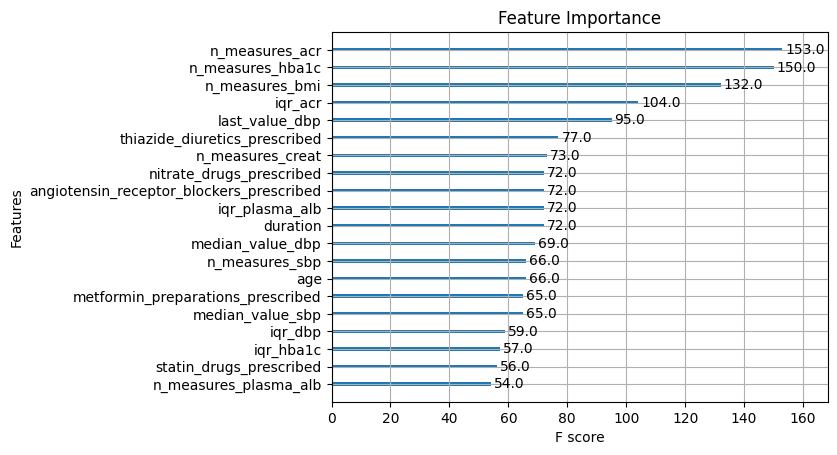

In [92]:
# Add 'real_or_synthetic' column
generated_subset['real_or_synthetic'] = 'synthetic'
X_test_0_subset['real_or_synthetic'] = 'real'

# Combine the datasets
combined_df = pd.concat([generated_subset, X_test_0_subset], ignore_index=True)

# Split into features and target
X = combined_df.drop('real_or_synthetic', axis=1)
y = combined_df['real_or_synthetic']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'real' -> 0, 'synthetic' -> 1

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate on the test set
accuracy = xgb_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20)
plt.title('Feature Importance')
plt.show()


In [93]:
# Identify columns in X_test_0 that contain negative numbers and calculate percentage
negative_columns_info = {
    col: (X_test_0[col] < 0).mean() * 100 for col in X_test_0.columns if (X_test_0[col] < 0).any()
}

# Print the results
for col, percentage in negative_columns_info.items():
    print(f"{col}: {percentage:.2f}% negative")


In [94]:
# Create the target variable y = (age < 60)?
y_X_test_0_subset = (X_test_0_subset['age'] < 60).astype(int)
y_generated_subset = (generated_subset['age'] < 60).astype(int)

# Drop 'real_or_synthetic' column if it exists
for df in [X_test_0_subset, generated_subset]:
    if 'real_or_synthetic' in df.columns:
        df.drop('real_or_synthetic', axis=1, inplace=True)

# Remove 'age' from features
X_features_X_test_0_subset = X_test_0_subset.drop('age', axis=1)
X_features_generated_subset = generated_subset.drop('age', axis=1)

# Ensure the feature columns match in both datasets
common_columns = X_features_X_test_0_subset.columns.intersection(X_features_generated_subset.columns)
X_features_X_test_0_subset = X_features_X_test_0_subset[common_columns]
X_features_generated_subset = X_features_generated_subset[common_columns]

# Experiment 1: Trained on 80% of X_test_0_subset, tested on 20% of X_test_0_subset
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_features_X_test_0_subset,
    y_X_test_0_subset,
    test_size=0.2,
    random_state=42,
    stratify=y_X_test_0_subset
)

# Train XGBoost classifier for Experiment 1
xgb_model1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model1.fit(X_train1, y_train1)

# Evaluate on the test set
accuracy1 = xgb_model1.score(X_test1, y_test1)
print(f"Trained on real -> tested on real - Accuracy: {accuracy1:.4f}")

# Experiment 2: Trained on 80% of generated_subset, tested on 20% of X_test_0_subset
X_train2, _, y_train2, _ = train_test_split(
    X_features_generated_subset,
    y_generated_subset,
    test_size=0.2,
    random_state=42,
    stratify=y_generated_subset
)

# Use X_test1 and y_test1 from Experiment 1 as the test set
# Train XGBoost classifier for Experiment 2
xgb_model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model2.fit(X_train2, y_train2)

# Evaluate on the test set
accuracy2 = xgb_model2.score(X_test1, y_test1)
print(f"Trained on synthetic -> tested on real - Accuracy: {accuracy2:.4f}")

# Plot feature importance for Experiment 1
# plt.figure(figsize=(10, 8))
# plot_importance(xgb_model1, max_num_features=20)
# plt.title('Feature Importance - Experiment 1')
# plt.show()

# # Plot feature importance for Experiment 2
# plt.figure(figsize=(10, 8))
# plot_importance(xgb_model2, max_num_features=20)
# plt.title('Feature Importance - Experiment 2')
# plt.show()


Trained on real -> tested on real - Accuracy: 0.8710
Trained on synthetic -> tested on real - Accuracy: 0.8400


In [95]:
# import shap
# import matplotlib.pyplot as plt

# # Compute SHAP values
# explainer = shap.Explainer(xgb_model, X_train)
# shap_values = explainer(X_test)

# # Beeswarm plot
# plt.figure(figsize=(12, 8))
# shap.summary_plot(shap_values, X_test, plot_type="bee")
# plt.title("SHAP Beeswarm Plot")
# plt.show()


In [96]:
print("Real_real_accuracy\tSynthetic_real_accuracy\tSynthetic_vs_original_MSE\tReal_vs_synthetic_discriminator_accuracy\tTraining_runtime")
print(f"{round(accuracy1,3)}\t{round(accuracy2,3)}\t{round(mse_3,0)}\t{round(accuracy,5)}\t{round(training_runtime,2)}")

sb.glue("Real_real_accuracy", accuracy1)
sb.glue("Synthetic_real_accuracy", accuracy2)
sb.glue("Synthetic_vs_original_MSE", mse_3)
sb.glue("Real_vs_synthetic_discriminator_accuracy", accuracy)
sb.glue("Training_runtime", training_runtime)

Real_real_accuracy	Synthetic_real_accuracy	Synthetic_vs_original_MSE	Real_vs_synthetic_discriminator_accuracy	Training_runtime
0.871	0.84	483.0	0.99675	427.22


KL divergence - difference between real data distribution and synthetic data distribution

In [97]:
# def calculate_kl_divergence(p, q):
#     # Add a small smoothing factor to avoid zero probabilities
#     p = p + 1e-10
#     q = q + 1e-10
    
#     # Normalize the distributions
#     p = p / np.sum(p)
#     q = q / np.sum(q)
    
#     return entropy(p, q)

# kl_divergences = []

# for column in column_names:
#     original_col = X_test_0_subset[column]
#     synthetic_col = synthetic_data[column]

#     # Calculate the histograms of the original and synthetic data for each column
#     original_hist, _ = np.histogram(original_col, bins=50, density=True)
#     synthetic_hist, _ = np.histogram(synthetic_col, bins=50, density=True)

#     # Calculate the KL divergence for each column
#     kl_divergence = calculate_kl_divergence(original_hist, synthetic_hist)
#     kl_divergences.append(kl_divergence)

# # Calculate the average KL divergence across all columns
# average_kl_divergence = np.mean(kl_divergences)

# print(f"Average KL Divergence: {average_kl_divergence:.3f}")

Moment matching score - (average normalised MSE for mean, variance, skewness and kurtosis between distributions)

In [98]:
# def moment_matching_score(real_moments, synthetic_moments):
#     normalized_diff = ((real_moments - synthetic_moments) / real_moments) ** 2
#     mse = np.mean(normalized_diff, axis=0)
#     return np.mean(mse)

# moment_score = moment_matching_score(np.array(real_moments), np.array(synthetic_moments))
# print(f"Moment Matching Score: {moment_score:.3f}")

In [99]:
# mmd_synthetic = synthetic_data.sample(n=1000, replace=True)
# mmd_X_test = X_test_0_subset.sample(n=1000, replace=True)

# def compute_kernel(x, y):
#     x_size = tf.shape(x)[0]
#     y_size = tf.shape(y)[0]
#     dim = tf.shape(x)[1]
    
#     x = tf.expand_dims(x, 1)  # (x_size, 1, dim)
#     y = tf.expand_dims(y, 0)  # (1, y_size, dim)
    
#     tiled_x = tf.tile(x, [1, y_size, 1])
#     tiled_y = tf.tile(y, [x_size, 1, 1])
    
#     kernel_input = tf.reduce_mean(tf.pow(tiled_x - tiled_y, 2), axis=2) / tf.cast(dim, tf.float64)
#     return tf.exp(-kernel_input)  # (x_size, y_size)

# def compute_mmd(x, y):
#     ''' Given the fake (x) and real (y) data, return the MMD
#     '''
#     x_kernel = compute_kernel(x, x)
#     y_kernel = compute_kernel(y, y)
#     xy_kernel = compute_kernel(x, y)
    
#     mmd = tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
#     return mmd

# mmd_value = compute_mmd(mmd_X_test, mmd_synthetic).numpy()

# print(mmd_value)

In [100]:
# plot_density(X_test_0_subset, synthetic_data, 'Original', 'Synthetic')  

Feature plot for synthetic categorical features

In [101]:
# feature_comparison_plot(X_test_0_subset, synthetic_data, 'Original', 'Synthetic', embedding_features)

Print benchmark scores and feature plot

In [102]:
# # feature_comparison_plot(X_test_0_subset, synthetic_data, 'Original', 'Synthetic', numerical_features)

# print("Training_runtime\tTraining_loss\tSynthetic_vs_original_MSE\tAverage_kl_divergence\tMoment_matching_score\tMax_mean_discrepancy")
# print(f"{round(training_runtime,1)}\t{round(training_loss,4)}\t{round(mse_3,0)}\t{round(average_kl_divergence,2)}\t{round(moment_score,3)}\t{round(mmd_value,3)}")

In [103]:
# import os
# import pandas as pd

# # Set the base directory for saving the files
# base_save_dir = '/home/shogg/mwdh_ml_projects/data/synthetic data'

# # Ensure the directory exists
# os.makedirs(base_save_dir, exist_ok=True)

# # Function to save a dataframe
# def save_dataframe(df, filename):
#     full_path = os.path.join(base_save_dir, filename)
#     df.to_csv(full_path, index=False)
#     print(f"Saved: {full_path}")

# # Save unconditional data
# for condition, data in unconditional_data_dict.items():
#     filename = f"unconditional_synthetic_10k.csv"
#     save_dataframe(pd.DataFrame(data), filename)

# # Save drug condition data
# for drug, conditions in synthetic_drug_data_dict.items():
#     for condition, data in conditions.items():
#         filename = f"{drug}_{condition}_synthetic_10k.csv"
#         save_dataframe(pd.DataFrame(data), filename)

# # Save categorical condition data
# for feature, conditions in synthetic_cat_data_dict.items():
#     for condition, data in conditions.items():
#         if feature == 'dm_type':
#             clean_condition = condition.replace(f'{feature}_', '')
#         else:
#             clean_condition = condition.split('_', 1)[1]
#         filename = f"{feature}_{clean_condition}_synthetic_10k.csv"
#         save_dataframe(pd.DataFrame(data), filename)

# print("All synthetic data has been saved.")

In [104]:
# import pandas as pd

# def create_summary_table(synthetic_cat_data_dict, value_to_column):
#     rows = []

#     for feature, conditions in synthetic_cat_data_dict.items():
#         for condition, data in conditions.items():
#             if condition != 'unconditional':
#                 if feature == 'dm_type':
#                     clean_condition = condition.replace(f'{feature}_', '')
#                     correct_count = (data[feature] == value_to_column[feature].index(condition)).sum()
#                 else:
#                     clean_condition = condition.split('_', 1)[1]
#                     correct_count = (data[feature] == clean_condition).sum()
                
#                 percentage = (correct_count / len(data)) * 100
#                 rows.append({
#                     'Feature': feature,
#                     'Condition': clean_condition,
#                     '% Correct': f"{percentage:.2f}%"
#                 })

#     return pd.DataFrame(rows)

# # Create the summary table
# summary_table = create_summary_table(synthetic_cat_data_dict, value_to_column)

# # Display the table
# print(summary_table.to_string(index=False))

# # Optionally, save to CSV
# # summary_table.to_csv('synthetic_data_summary.csv', index=False)

In [105]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import math

# # Set up the plot
# n_drugs = len(prescribed_conditional_features)
# n_cols = 2
# n_rows = math.ceil(n_drugs / 2)

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows), squeeze=False)
# axs = axs.flatten()

# colors = {'unconditional': 'blue', 'prescribed': 'green', 'not_prescribed': 'red'}

# for i, drug in enumerate(prescribed_conditional_features):
#     ax = axs[i]
    
#     for condition in ['unconditional', 'prescribed', 'not_prescribed']:
#         data = synthetic_data_dict[drug][condition][drug]
#         sns.kdeplot(data=data, ax=ax, color=colors[condition], label=condition)
    
#     ax.axvline(x=0.5, color='black', linestyle='--')
#     ax.set_title(f'{drug}')
#     ax.set_xlabel('Prescription Count')
#     ax.set_ylabel('Density')

# # Remove any unused subplots
# for j in range(i+1, len(axs)):
#     fig.delaxes(axs[j])

# plt.tight_layout()

# # Add a single legend for the entire figure
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

# plt.show()

In [106]:
# def save_datasets_csv(real_data, synthetic_data, save_path, real_filename='real_data.csv', synthetic_filename='synthetic_data.csv'):
#     """
#     Save real and synthetic datasets as CSV files.
    
#     Parameters:
#     real_data (pd.DataFrame): DataFrame containing real data
#     synthetic_data (pd.DataFrame): DataFrame containing synthetic data
#     save_path (str): Directory path to save the CSV files
#     real_filename (str): Filename for the real data CSV
#     synthetic_filename (str): Filename for the synthetic data CSV
#     """
#     # Ensure the save directory exists
#     os.makedirs(save_path, exist_ok=True)
    
#     # Save real data
#     real_path = os.path.join(save_path, real_filename)
#     real_data.to_csv(real_path, index=False)
#     print(f"Real data saved to {real_path}")
    
#     # Save synthetic data
#     synthetic_path = os.path.join(save_path, synthetic_filename)
#     synthetic_data.to_csv(synthetic_path, index=False)
#     print(f"Synthetic data saved to {synthetic_path}")

# # Usage example:
# save_datasets_csv(X_test_0_subset, synthetic_data, '/home/shogg/mwdh_ml_projects/data')